In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
!bash brain-tumor-segmentation-unet/download_data.sh
!python brain-tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
Cloning into 'brain-tumor-segmentation-unet'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 37 (delta 3), reused 2 (delta 2), pack-reused 32 (from 1)
Receiving objects: 100% (37/37), 1.21 MiB | 8.85 MiB/s, done.
Resolving deltas: 100% (6/6), done.
3064
/kaggle/working/brain-tumor-segmentation-unet/mat_to_numpy.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(mat_file[0]))
[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


Labels: (3064,)
Images: (3064, 512, 512)
Masks : (3064, 512, 512)


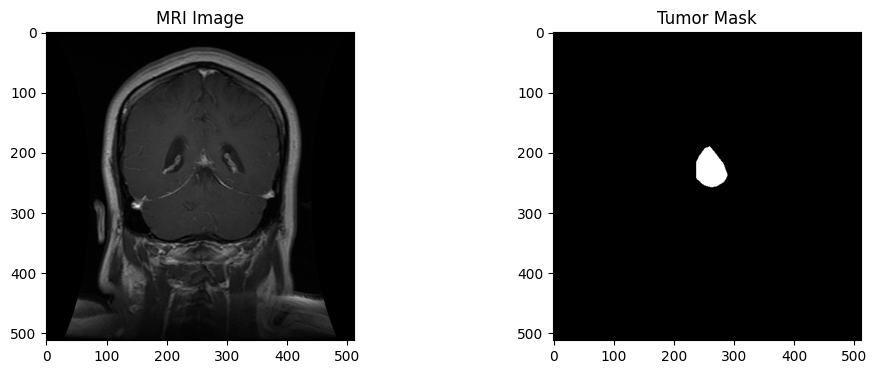

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the converted .npy files
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.clip(np.load('brain_tumor_dataset/images.npy') / 12728, 0, 1)
masks  = np.load('brain_tumor_dataset/masks.npy')

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}


print("Labels:", labels.shape)
print("Images:", images.shape)
print("Masks :", masks.shape)

# View a sample
i = 0
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(images[i], cmap='gray')
plt.subplot(1,2,2)
plt.title("Tumor Mask")
plt.imshow(masks[i], cmap='gray')
plt.show()


In [4]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)  

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


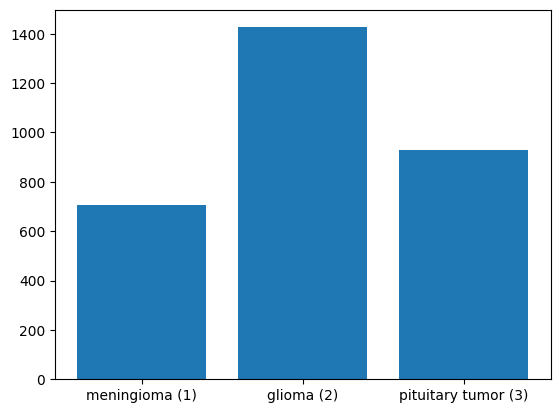

In [5]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

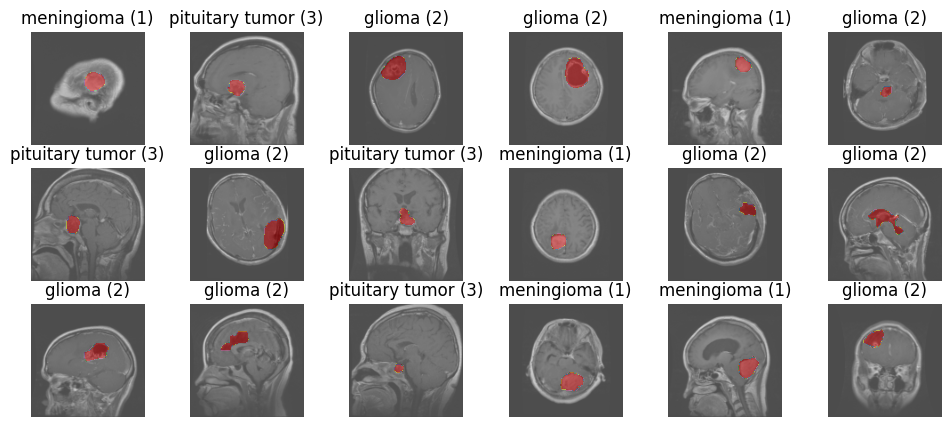

In [6]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

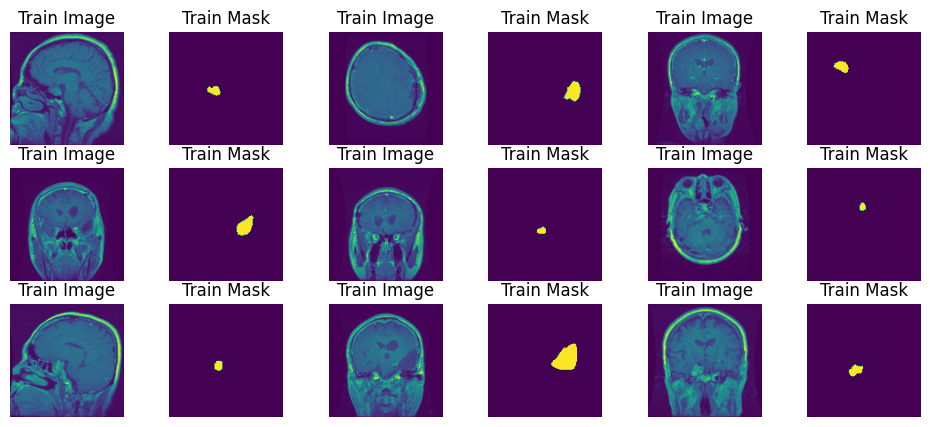

In [7]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1)) 
  plt.title("Train Mask")
  plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

In [9]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    brightness_range=(0.9, 1.1),
    zoom_range=[0.9, 1.1],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()


In [11]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [12]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  

inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()
     

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_1_1 (Conv2D)  │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_1_2 (Conv2D)  │ (None, 128, 128, 64)   │         36,928 │ contraction_1_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ contraction_1_2[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_2_1_1         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_2_1_2         │ (None, 64, 64, 128)    │        147,584 │ contraction_2_1_1[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ contraction_2_1_2[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 128)    │            512 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_3_1_1         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_3_1_2         │ (None, 32, 32, 256)    │        590,080 │ contraction_3_1_1[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ contraction_3_1_2[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 256)    │          1,024 │ max_pooling2d_2[0][0]  │
│ (BatchNormalization) 

 Total params: 22,718,529 (86.66 MB)

 Trainable params: 22,716,609 (86.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [13]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy', iou_metric])


In [14]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ====================
# Custom Loss Functions
# ====================


def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
# ====================
# Custom IoU Metric
# ====================

def get_iou_vector(A, B):
    t = A > 0
    p = B > 0
    intersection = np.logical_and(t, p)
    union = np.logical_or(t, p)
    iou = (np.sum(intersection) + 1e-10) / (np.sum(union) + 1e-10)
    return iou

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    
    return tf.reduce_mean(iou)


model_checkpoint = ModelCheckpoint('model_best_checkpoint.keras', 
                                   save_best_only=True, 
                                   monitor='val_loss', 
                                   mode='min', 
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               mode='min')

reduceLR = ReduceLROnPlateau(patience=4, 
                             verbose=2, 
                             monitor='val_loss', 
                             min_lr=1e-4, 
                             mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(brightness_range=(0.9, 1.1),
                                   zoom_range=[.9, 1.1],
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator()


unet.compile(optimizer=Adam(learning_rate=1e-3), 
             loss=bce_dice_loss, 
             metrics=['accuracy', iou_metric])


hist = unet.fit(X, Y,
                batch_size=32,
                epochs=10,
                validation_data=(X_v, Y_v),
                verbose=1,
                callbacks=callback_list)

unet = load_model('model_best_checkpoint.keras', 
                  custom_objects={'bce_dice_loss': bce_dice_loss, 'iou_metric': iou_metric})


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9657 - iou_metric: 0.0640 - loss: 0.9924
Epoch 1: val_loss improved from inf to 0.92504, saving model to model_best_checkpoint.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 197s 883ms/step - accuracy: 0.9658 - iou_metric: 0.0645 - loss: 0.9913 - val_accuracy: 0.9847 - val_iou_metric: 0.0995 - val_loss: 0.9250 - learning_rate: 0.0010
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9848 - iou_metric: 0.3584 - loss: 0.5643
Epoch 2: val_loss improved from 0.92504 to 0.45920, saving model to model_best_checkpoint.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 509ms/step - accuracy: 0.9848 - iou_metric: 0.3587 - loss: 0.5639 - val_accuracy: 0.9881 - val_iou_metric: 0.4472 - val_loss: 0.4592 - learning_rate: 0.0010
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9883 - iou_metric: 0.4608 - loss: 0.4291
Epoch 3: val_loss did not improve from 0.45920
154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 499ms/step - accuracy: 0

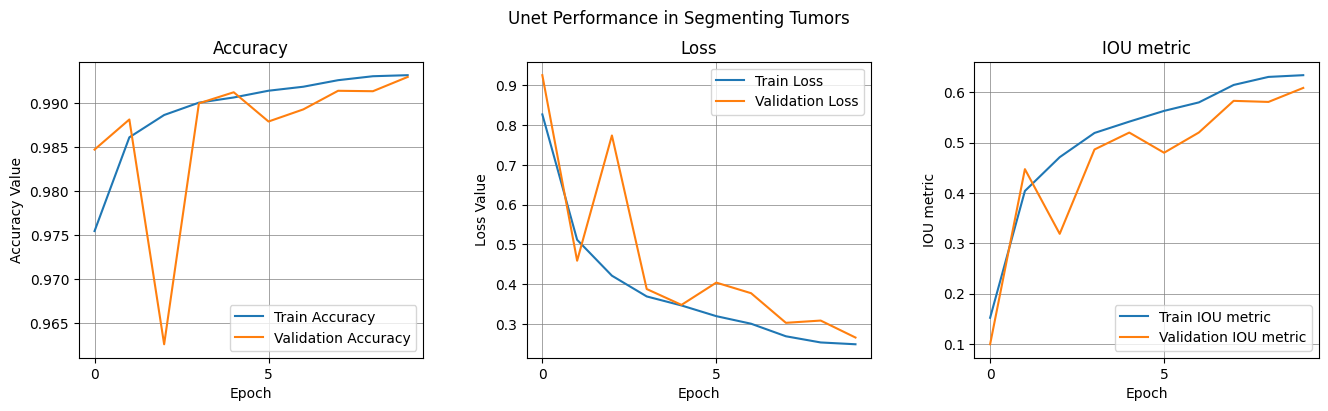

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

# Corrected Accuracy Plot
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1]+1, 5))
ax1.set_ylabel('Accuracy Value'); ax1.set_xlabel('Epoch'); ax1.set_title('Accuracy')
ax1.legend(loc="best"); ax1.grid(color='gray', linestyle='-', linewidth=0.5)

# Loss Plot
ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1]+1, 5))
ax2.set_ylabel('Loss Value'); ax2.set_xlabel('Epoch'); ax2.set_title('Loss')
ax2.legend(loc="best"); ax2.grid(color='gray', linestyle='-', linewidth=0.5)

# IOU Plot
ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1]+1, 5))
ax3.set_ylabel('IOU metric'); ax3.set_xlabel('Epoch'); ax3.set_title('IOU metric')
ax3.legend(loc="best"); ax3.grid(color='gray', linestyle='-', linewidth=0.5)


In [16]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
  
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 188ms/step


Text(0.5, 1.0, 'Threshold vs IoU (0.21212121212121213, 0.6980920013060344)')

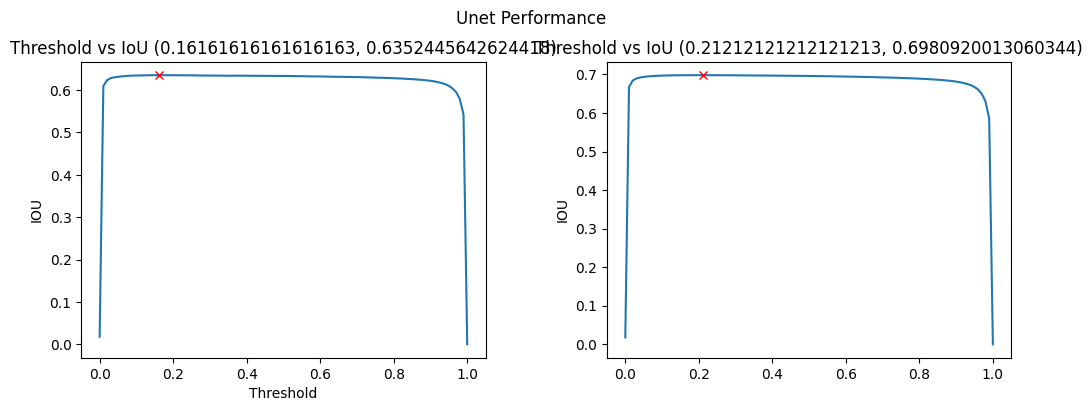

In [17]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step


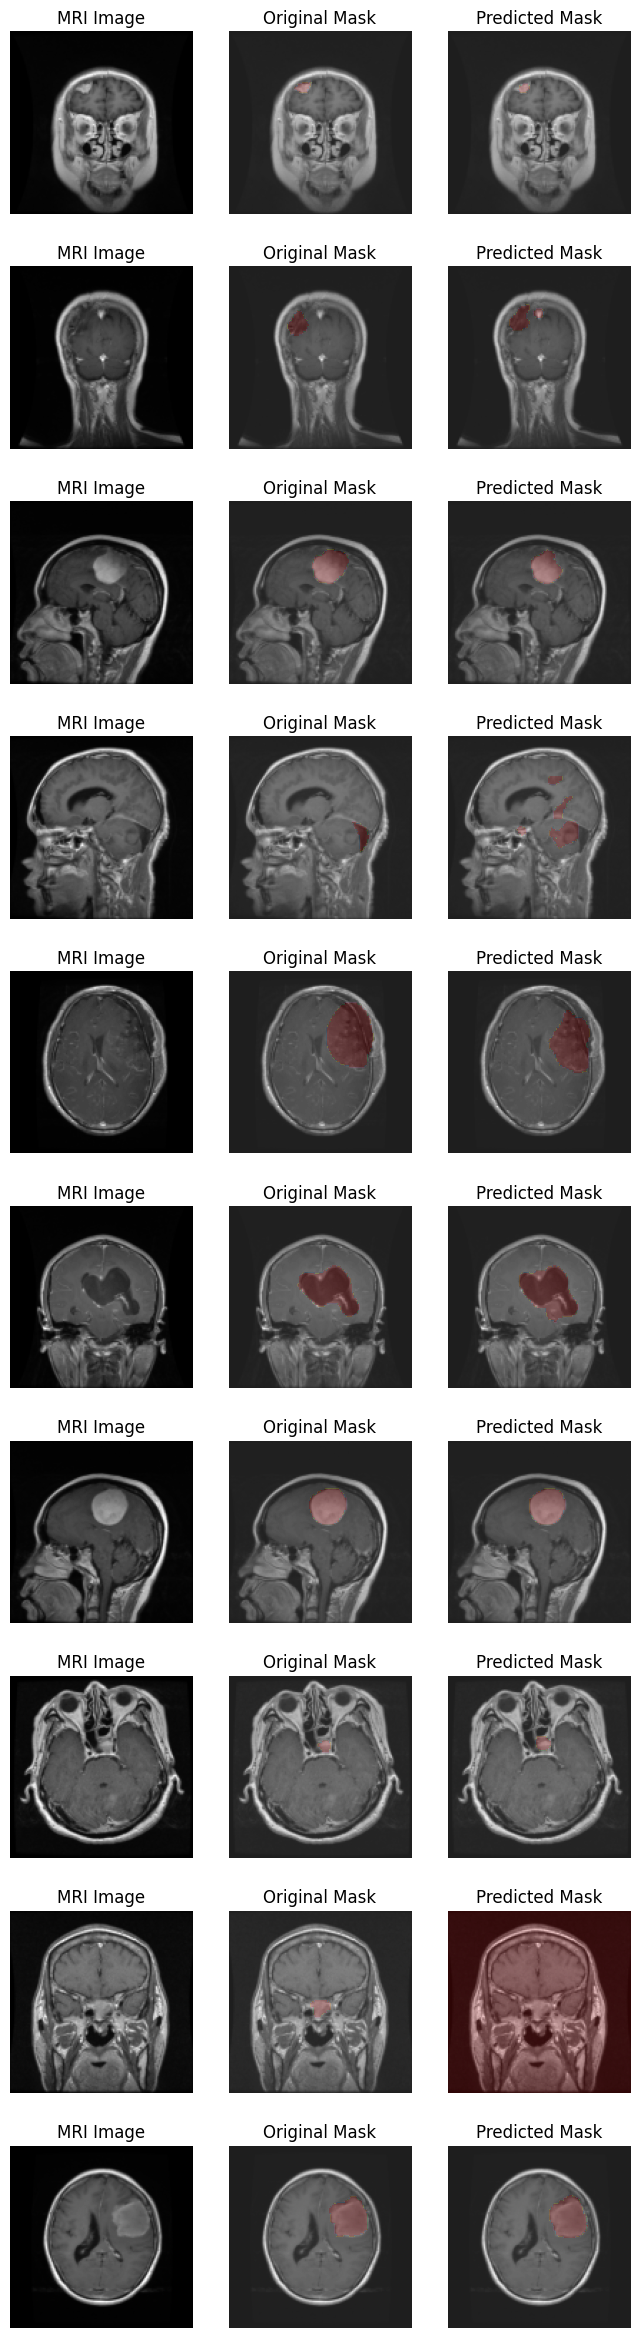

In [18]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

In [19]:
unet.save('modelsegmentation.h5')

In [20]:
from IPython.display import FileLink
FileLink(r'modelsegmentation.h5')

/kaggle/working/modelsegmentation.h5